In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn import metrics
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV

In [6]:
df=pd.read_csv('forestfires.csv')
df.shape

(517, 13)

In [7]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [15]:
df.isna().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [19]:
plt.rcParams["figure.figsize"] = 9,5

In [23]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Skew: 12.846933533934868
Kurtosis: 194.1407210942299


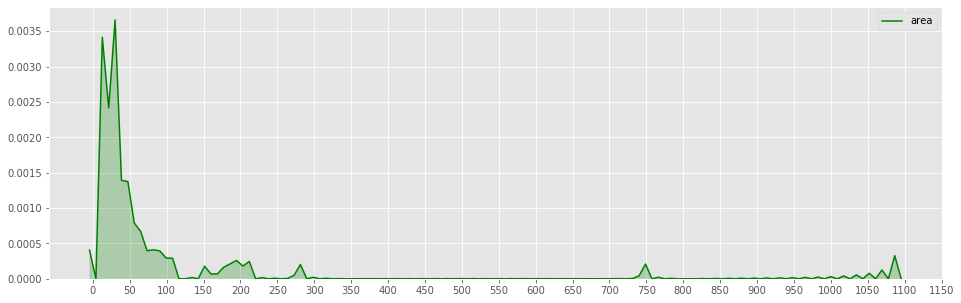

In [27]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df['area'].skew()))
print("Kurtosis: {}".format(df['area'].kurtosis()))
ax = sns.kdeplot(df['area'],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

In [28]:
y_outliers = df[abs(zscore(df['area'])) >= 3 ]
y_outliers

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


In [33]:
dfa = df.drop(columns='area')
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

cat_columns,num_columns

(['month', 'day'],
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])

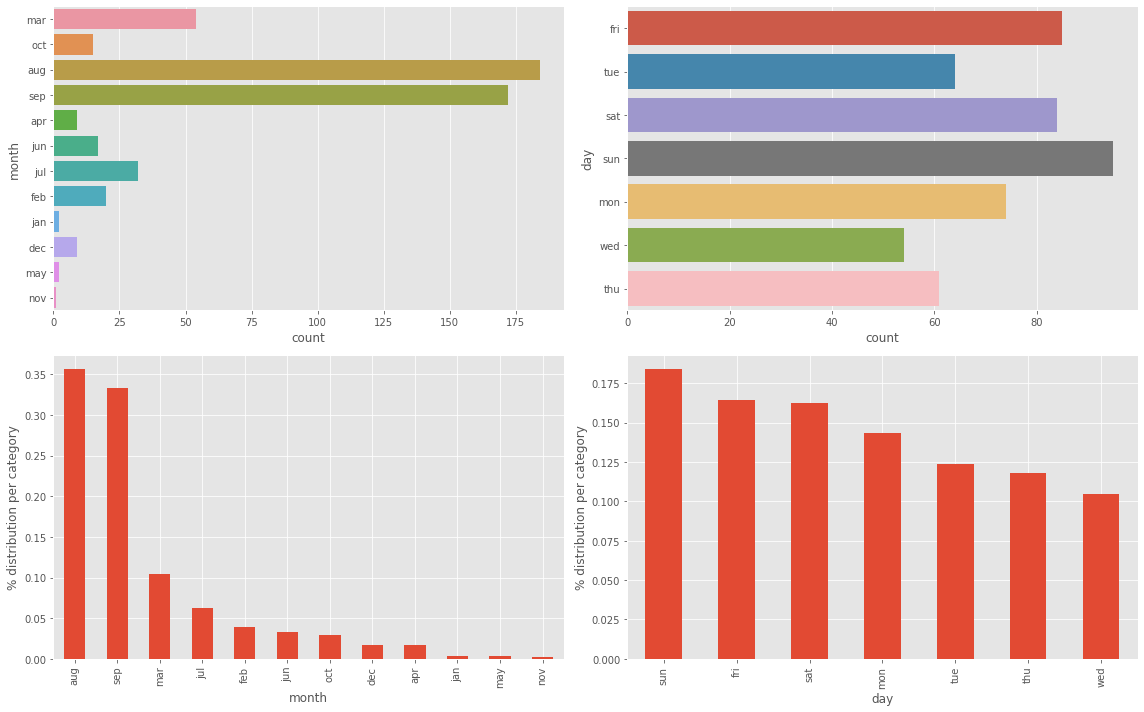

In [35]:
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel('% distribution per category')
    plt.xlabel(col)
plt.tight_layout()
plt.show()    

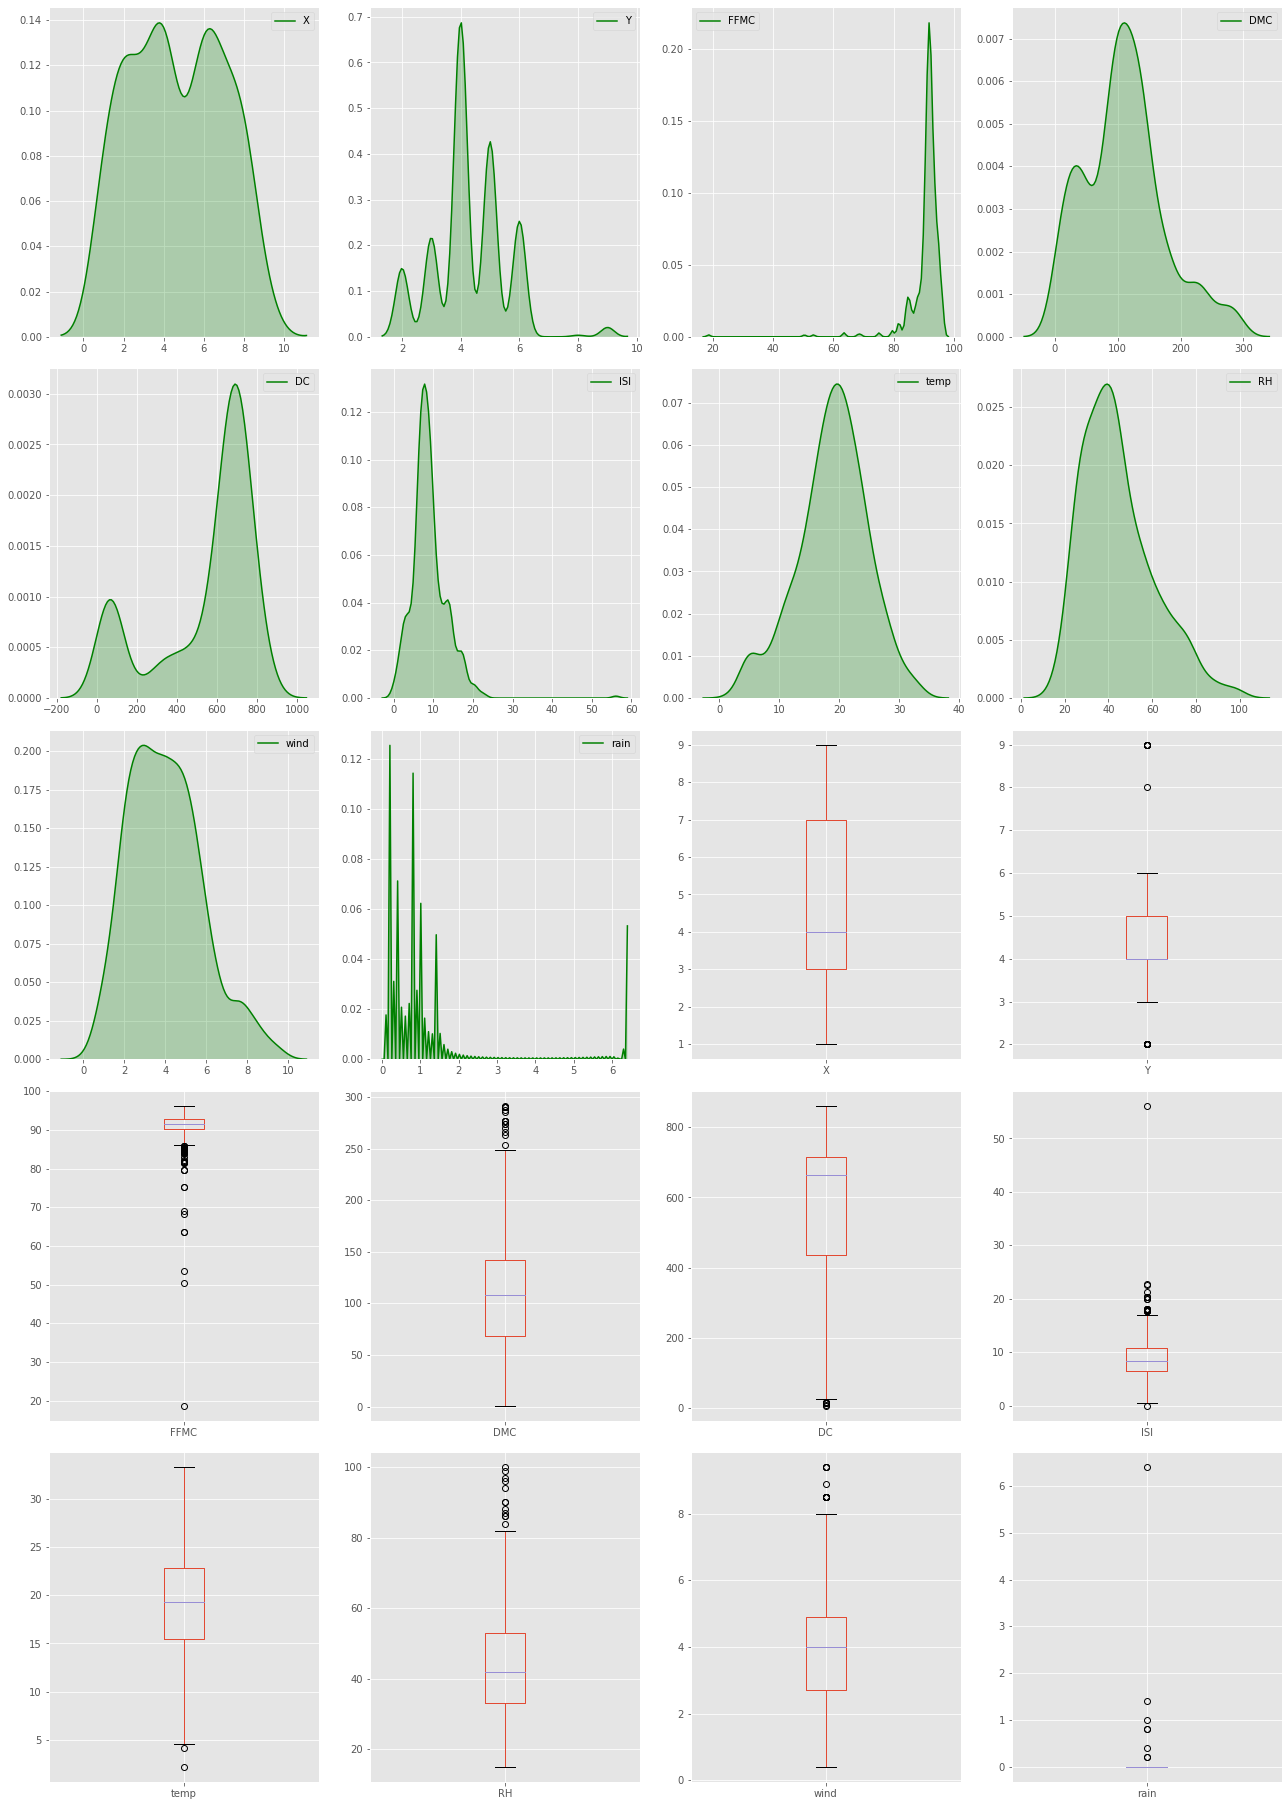

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,0.036246,0.417296,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,-1.172331,1.420553,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


In [36]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [37]:
print(df['area'].describe(),'\n')
print(y_outliers)

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain     area
237  1  2   sep  tue  91.0  129.5  692.6   7.0  18.8  40   2.2   0.0   212.88
238  6  5   sep  sat  92.5  121.1  674.4   8.6  25.1  27   4.0   0.0  1090.84
415  8  6   aug  thu  94.8  222.4  698.6  13.9  27.5  27   4.9   0.0   746.28
479  7  4   jul  mon  89.2  103.9  431.6   6.4  22.6  57   4.9   0.0   278.53


In [38]:
def area_cat(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


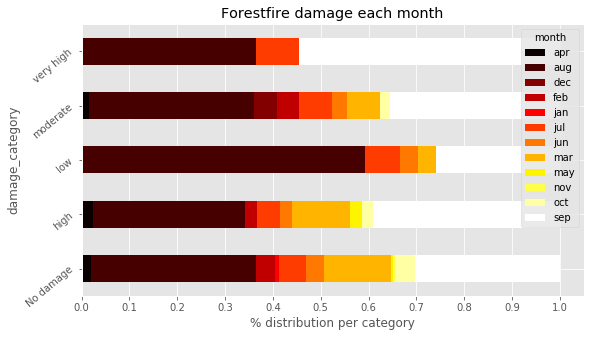

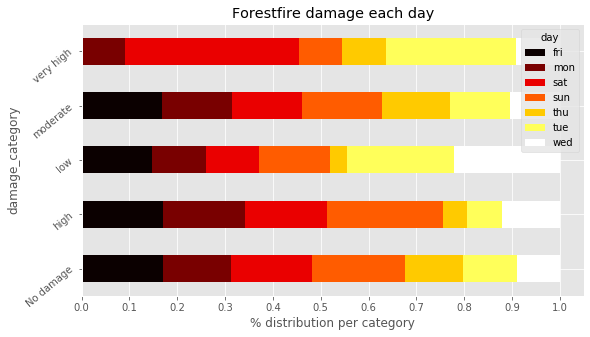

In [39]:
for col in cat_columns:
    cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
    cross.plot.barh(stacked=True,rot=40,cmap='hot')
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0,1.1,0.1))
    plt.title("Forestfire damage each {}".format(col))
plt.show()

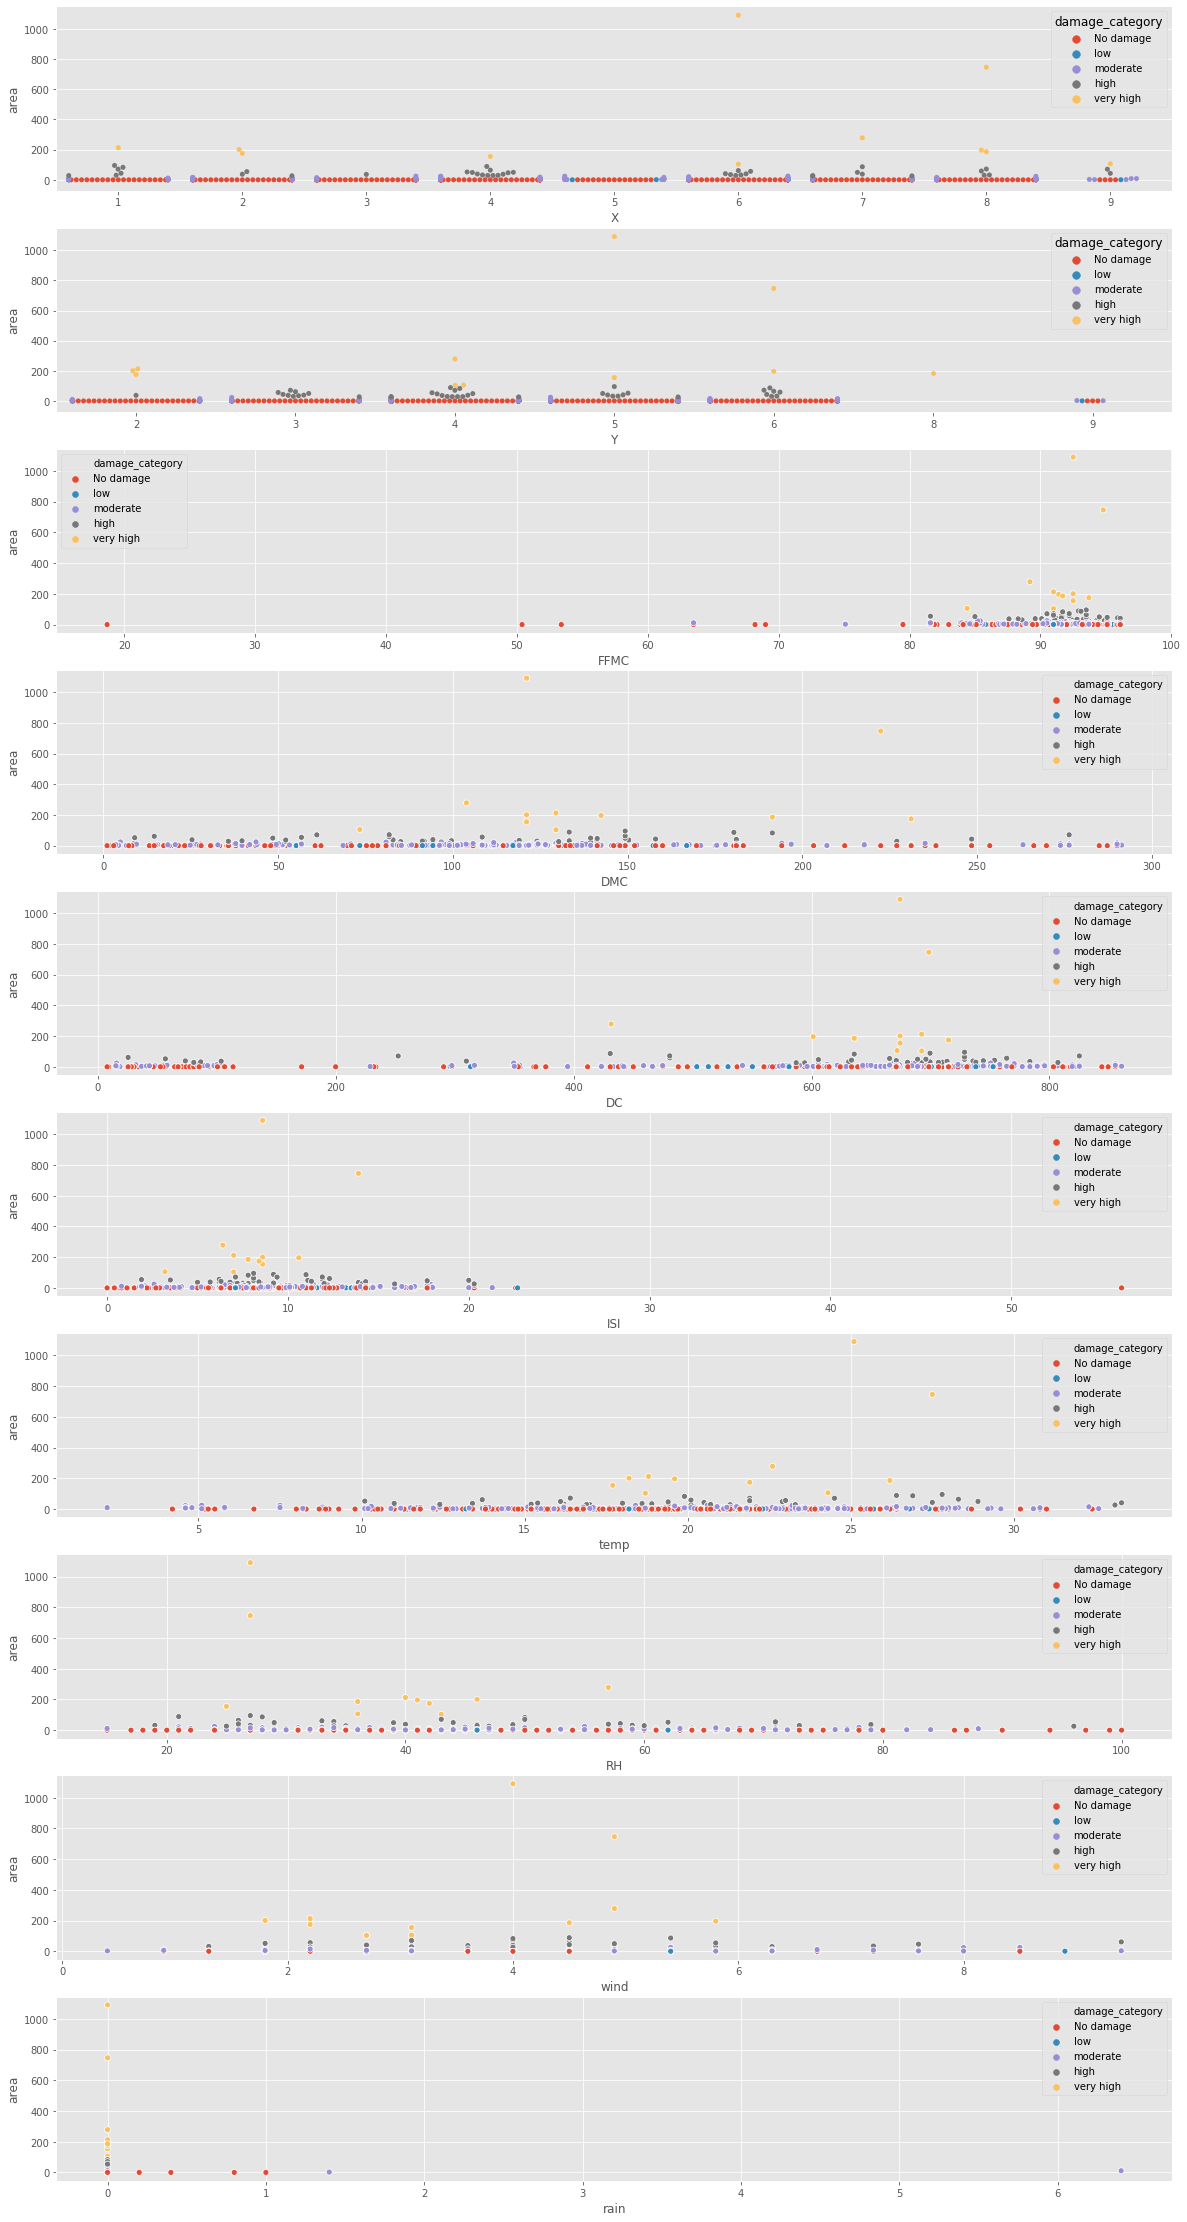

In [42]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,1,i)
    if col in ['X','Y']:
        sns.swarmplot(data=df,x=col,y='area',hue='damage_category')
    else:
        sns.scatterplot(data=df,x=col,y='area',hue='damage_category')
plt.show()

In [43]:
selected_features = df.drop(columns=['damage_category','day','month']).columns
selected_features

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area'],
      dtype='object')

In [44]:
out_columns = ['area','FFMC','ISI','rain']

In [45]:
df = pd.get_dummies(df,columns=['day','month'],drop_first=True)
df.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,0,1,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,0,1,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,0,1,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,0,1,0,0,0,0


In [46]:
print(df[out_columns].describe())
np.log1p(df[out_columns]).skew(), np.log1p(df[out_columns]).kurtosis()

              area        FFMC         ISI        rain
count   517.000000  517.000000  517.000000  517.000000
mean     12.847292   90.644681    9.021663    0.021663
std      63.655818    5.520111    4.559477    0.295959
min       0.000000   18.700000    0.000000    0.000000
25%       0.000000   90.200000    6.500000    0.000000
50%       0.520000   91.600000    8.400000    0.000000
75%       6.570000   92.900000   10.800000    0.000000
max    1090.840000   96.200000   56.100000    6.400000


(area     1.217838
 FFMC   -11.675394
 ISI     -0.937218
 rain    14.173028
 dtype: float64, area      0.945668
 FFMC    185.482383
 ISI       2.584588
 rain    234.240025
 dtype: float64)

In [47]:
mask = df.loc[:,['FFMC']].apply(zscore).abs() < 3
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

df = df[mask.values]
df.shape

(510, 29)

In [48]:
out_columns.remove('rain')
df[out_columns] = np.log1p(df[out_columns])

In [51]:
df[out_columns].skew()

area    1.208492
FFMC   -1.803993
ISI    -0.434372
dtype: float64

In [52]:
df_ml = df.drop(columns=['damage_category']).copy()

In [53]:
X = df.drop(columns=['area','damage_category'])
y = df['area']

In [54]:
lr = LinearRegression()
lr.fit(X, y)

print(f'Intercept: {lr.intercept_}')
print(f'R^2 score: {lr.score(X, y)}')
pd.DataFrame({"Coefficients": lr.coef_}, index=X.columns)

Intercept: 0.3192068355158235
R^2 score: 0.0769861533829217


,Coefficients
X,0.053161
Y,-0.011457
FFMC,-0.106058
DMC,0.004149
DC,-0.001854
ISI,-0.103922
temp,0.044297
RH,0.004063
wind,0.067775
rain,-0.927225
